# Приоритизация гипотез и анализ A/B-теста в крупном интернет-магазине

В проекте ставится задача, во-первых, проанализировать список гипотез, подготовленный отделом маркетинга крупного интернет-магазина для увеличения выручки, и приоритизировать представленные гипотезы. Во-вторых, требуется проанализировать результаты проведенного в компании A/B-теста. На основе анализа сделать выводы относительно ключевых метрик подгрупп теста, а также принять решение, стоит ли продолжать тест или же его стоит остановить.

## Оглавление

### [Приоритизация гипотез](#Приоритизация_гипотез)

[1) Загрузка данных и обозначения переменных](#Загрузка_данных_и_обозначения_переменных)

[2) Приоритизация гипотез по фреймворкам ICE и RICE](#Приоритизация_гипотез_по_фреймворкам)

[Выводы](#Выводы_1)

### [Анализ A/B-теста. Подготовка данных](#Анализ_AB_теста_Подготовка_данных)

[1) Загрузка и подготовка данных](#Загрузка_и_подготовка_данных)

[2) Характерные значения переменных](#Характерные_значения_переменных)

[Выводы](#Выводы_2)

### [Анализ A/B-теста. Формирование выводов](#Анализ_AB_теста_Формирование_выводов)

[1) Рассчет кумулятивных показателей](#Рассчет_кумулятивных_показателей)

[2) Анализ выбросов в данных](#Анализ_выбросов_в_данных)

[3) Определение статистической значимости различий в группах теста](#Определение_статистической_значимости_различий_в_группах_теста)

[Выводы](#Выводы_3)

### [Общий вывод](#Общий_вывод)

<a id='Приоритизация_гипотез'></a>
## Приоритизация гипотез

В данном разделе проекта займемся приоритизацией подготовленных гипотез. Их проверка потенциально может указать точки роста выручнки интернет-магазина. Начнем с загрузки и изучения данных о гипотезах.

<a id='Загрузка_данных_и_обозначения_переменных'></a>
### 1) Загрузка данных и обозначения переменных

Импортируем библитеки, которые понадобятся на протяжении всего проекта:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

Прочитаем csv-файл с гипотезами. Используем для чтения файла метод `read_csv`. Датафрейм с данными о гипотезах назовем `hypothesis`:

In [2]:
# Параметр max_colwidth передаем, чтобы отображать в ячейках всю строку целиком без сокращений
pd.set_option('max_colwidth', None)

hypothesis = pd.read_csv('hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Всего имеем 9 гипотез. Формулировка каждой гипотезы содержится в столбце `Hypothesis` датасета `hypothesis`. Для каждой гипотезы по шкале от 1 до 10 оценены следующие факторы:

- `Reach` - охват пользователей,
- `Impact` - влияние на пользователей,
- `Confidence` - уверенность в гипотезе,
- `Efforts` - затраты ресурсов на проверку гипотезы (чем больше значение `Efforts`, тем дороже проверка гипотезы).

Проверим, что типы данных фигурирующих в датасете `hypothesis` подходят для проведения дальнейшего анализа. Типы данных извлечем методом `dtypes`:

In [3]:
hypothesis.dtypes

Hypothesis    object
Reach          int64
Impact         int64
Confidence     int64
Efforts        int64
dtype: object

Все верно: `Hypothesis` - описание гипотез - имеет тип данных *object*, остальные параметры гипотез имеют тип *int*, что позволяет производить дальныейшие рассчеты. Перейдем непосредственно к осуществлению приоритизации гипотез.

<a id='Приоритизация_гипотез_по_фреймворкам'></a>
### 2) Приоритизация гипотез по фреймворкам ICE и RICE

Приоритизировать гипотезы можно различными способами. Разные фреймворки оценки значимости гипотез содержат несколько отличающиеся параметры, которые учитываются в процессе приоритизации гипотез. В данном проекте будем использовать фреймворки ICE и RICE.

Фреймворк ICE состоит из трех компонент: 

**ICE = Impact (влияние на пользователей) * Confidence (уверенность в гипотезе) * Ease (простота проверки гипотезы)** 

или, через затраты, 

**ICE = Impact (влияние на пользователей) * Confidence (уверенность в гипотезе) / Efforts (затраты ресурсов на проверку гипотезы)**.

Рассчитаем параметр ICE для каждой из представленных гипотез:

In [4]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']).round(2)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20


Отсортируем гипотезы в порядке убывания параметра ICE методом `sort_values`:

In [5]:
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Согласно оценке важности гипотез по методу ICE, первой следует проверить гипотезу с индексом 8, предлагающую **запустить акцию с предложением скидки**. Для нее показатель ICE равен 16,2. На втором месте, среди потенциально наиболее выгодных гипотез, гипотеза о **добавлении двух новых каналов привлечения трафика** (ICE = 13,3). Замыкает тройку самых перспективных гипотез предложение **добавить форму подписки на основные страницы магазина** (ICE = 11,2). Все три гипотезы-лидера имеют среднюю оценку по затратам усилий на их проверку (Efforts = 5-6) и высокие показатели влияния на пользователей (Impact = 7-10), а также уверенности в достоверности гипотез (Confidence = 8-9).

Теперь обратимся к другой модификации данного фреймворка - формулировке RICE:

**RICE = Reach (охват пользователей) * Impact (влияние на пользователей) * Confidence (уверенность в гипотезе) / Efforts (затраты ресурсов на проверку гипотезы)**.

Добавился параметр Reach, который указывает на количество пользователей, которых затронет изменение предложенное в гипотезе. Если та или иная гипотеза подтвердится, то с большего сегмента пользователей, потенциально, можно получить больше выручки.

Рассчитаем параметр RICE для наших гипотез и отсортируем гипотезы по значению этого показателя:

In [6]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact']\
    * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По методу RICE очередность проверки гипотез поменялась, по сравнению с методом ICE. Высокий показатель Reach = 10 вывел на первое место предложение **добавить форму подписки на основные страницы сайта** (RICE = 112). Это изменение каснется всех пользователей. Второе место в приоритизации гипотез заняла гипотеза о **добавлении блоков рекомендации товаров** (RICE = 56). Отметим, что затраты на проверку данной гипотезы не столь велики (Efforts = 3). Это позволит довольно быстро сделать выводы и перейти к проверке следующих гипотез. На третьем месте по фреймворку RICE гипотеза о **добавлении двух новых каналов привлечения трафика** (RICE = 40). Охват аудитории этой гипотезы небольшой (Reach = 3). Вероятно, маркетологи не ожидают, что из новых каналов придет трафик, превышающий существующий приток клиентов.

<a id='Выводы_1'></a>
## Выводы

В первом разделе проекта мы импортировали в ноутбук файл, содержащий гипотезы по увеличению выручки интернет-магазина, и осуществили приоритизацию данных гипотез двумя способами. Всего предложено 9 гипотез, для каждой из которых заранее были оценены показатели Reach (охват аудитории), Impact (влияние на пользователей), Confidence (уверенность в гипотезе) и Efforts (затраты на проверку гипотезы). Все упомянутые показатели оценивались по 10-бальной шкале: от 1 до 10.

Приоритизация предлагаемых гипотез производилась по двум фреймворкам: ICE и RICE. В данном разделе дается подробное пояснение того и другого метода. Согласно методу ICE, первой следует проверить гипотезу о запуске акции с предложением скидки. Для нее показатель ICE равен 16,2. На втором месте, среди потенциально наиболее выгодных гипотез, гипотеза о добавлении двух новых каналов привлечения трафика (ICE = 13,3). Замыкает тройку самых перспективных гипотез предложение добавить форму подписки на основные страницы магазина (ICE = 11,2).

С учетом охвата доли пользователей изменениями той или иной гипотезы (параметр Reach), порядок приоритизации гипотез поменятся. По методу RICE, первой следует проверить гипотезу с предложением добавить форму подписки на основные страницы сайта (RICE = 112). Это изменение каснется всех пользователей (Reach = 10). Второе место заняла гипотеза о добавлении блоков рекомендации товаров (RICE = 56). Затраты на проверку данной гипотезы оценены в 3 балла из 10. На третьем месте по фреймворку RICE гипотеза о добавлении двух новых каналов привлечения трафика (RICE = 40). Охват аудитории этой гипотезы небольшой (Reach = 3).

Можно также отметить, что, несмотря на отличия, топ-5 гипотез по обоим фреймворкам совпадает.

Перейдем к следующему разделу проекта. В нем будем анализировать результаты A/B-теста.

<a id='Анализ_AB_теста_Подготовка_данных'></a>
## Анализ A/B-теста. Подготовка данных

Во этой части проекта займемся анализом результатов A/B-теста. Изучим и сравним различные метрики для подгрупп эксперимента, после чего примем решение о продолжении либо остановке тестирования. Начнем с загрузки данных - результатов тестирования - и изучения характерных значений присутствующих параметров.

<a id='Загрузка_и_подготовка_данных'></a>
### 1) Загрузка и подготовка данных

Результаты эксперимента храняться в двух файлах: в файле с информацией о визитах пользователей и в файле с информацией о сделанных заказах. Загрузим эти данные в два датафрейма. Назовем их `visitors` и `orders`, соответственно:

In [7]:
visitors = pd.read_csv('visitors.csv')
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [8]:
orders = pd.read_csv('orders.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Таблица `visitors` содержит данные о количесиве визитов пользователей из кажлой круппы эксперимента по дням. В датасете фигурируют следующие переменные:

- `date` - дата,
- `group` - группа A/B-теста (A или B),
- `visitors` - количество пользователей в указанную дату в указанной группе A/B-теста.

Вторая таблица - `orders` - содержит информацию о заказах в интернет-магазине. Ее переменные:

- `transactionId` - идентификатор заказа,
- `visitorId` - идентификатор пользователя, совершившего заказ,
- `date` - дата, когда был совершён заказ,
- `revenue` - выручка заказа,
- `group` - группа A/B-теста, в которую попал заказ.

Убедимся, что строки в датасетах не задублировались. Проверим отсутсвие дубликатов сочетанием методов `duplicated().sum()`:

In [9]:
for table in [visitors, orders]:
    print(table.duplicated().sum())

0
0


Дублирующихся строк в данных нет. В датасете `visitors` - 62 уникальные строки, в `orders` - 1197 уникальных строк.

Теперь проверим, все ли данные заполнены. Количество пропусков найдем методами `isna().sum()`:

In [10]:
for table in [visitors, orders]:
    display(table.isna().sum())

date        0
group       0
visitors    0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Данные в таблицах присутствуют в полном объеме, пропусков нет.

Получим теперь типы данных для переменных, содержащихся в `visitors` и `orders`, методом `dtypes`:

In [11]:
for table in [visitors, orders]:
    display(table.dtypes)

date        object
group       object
visitors     int64
dtype: object

transactionId     int64
visitorId         int64
date             object
revenue           int64
group            object
dtype: object

Названия групп экспериментов `group` имеют тип *object*, идентификаторы заказа `transactionId` и пользователя `visitorId`, а также количество пользователей `visitors` и выручка с заказа `revenue`, имеют целочисленный тип данных *int*. Обе даты - как визитов пользователей, так и заказов - имеют тип данных *object*. Для удобства дальнейшей работы с датами, приведем эти две переменные к типу *datetime*. Воспользуемся для этого методом `to_datetime`:

In [12]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

# Проверяем корректность преобразования - вызываем типы данных переменных
for table in [visitors, orders]:
    display(table.dtypes)

date        datetime64[ns]
group               object
visitors             int64
dtype: object

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

Теперь с датами можно работать как с датами, а не со строками. Это понадобится нам в дальнейшем.

Преже чем переходить непосредственно к анализу результатов A/B-теста, составим представление, с какими характерными величинами мы имеем дело. Выявим типичные значения фигурирующих в данных переменных. Этому посвятим следующую часть данного раздела проекта. 

<a id='Характерные_значения_переменных'></a>
### 2) Характерные значения переменных

Начнем с датасета `visitors`. Изучим диапазон дат, за которые представлены данные о пользовательских визитах. Вызовем метод `describe`:

In [55]:
visitors['date'].describe(datetime_is_numeric=True)

count                     62
mean     2019-08-16 00:00:00
min      2019-08-01 00:00:00
25%      2019-08-08 06:00:00
50%      2019-08-16 00:00:00
75%      2019-08-23 18:00:00
max      2019-08-31 00:00:00
Name: date, dtype: object

Данные о количестве пользователей, совершивших визиты на сайт, представлены за месяц: с 1 по 31 августа 2019 года.

Посмотрим, как распределились визиты по группам A и B теста. Для группировки данных используем метод `groupby`:

In [14]:
visitors.groupby('group').agg({'visitors': 'sum'})

,visitors
group,
A,18736
B,18916


Пользователи разделились по группам практически поровну. Это правильное соотношение с точки зрения корректности проведения A/B-теста. 

Изучим количество пришедших на сайт пользователей в динамике по дням. Сделаем срезы данных, чтобы пронаблюдать отдельно группы A и B. Срезы данных получим методом `loc`:

In [15]:
# Делаем срезы данных по группам. Методом drop удаляем столбец с названием группы эксперимента
visitors_A = visitors.loc[visitors['group'] == 'A'].drop('group', axis=1)
visitors_B = visitors.loc[visitors['group'] == 'B'].drop('group', axis=1)

# Объединяем таблицы visitors_A и visitors_B методом merge
visitors_grouped = visitors_A.merge(visitors_B, on='date', how='outer')
visitors_grouped.columns = ['date', 'visitors_A', 'visitors_B']
visitors_grouped.head(10)

,date,visitors_A,visitors_B
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707
5,2019-08-06,667,655
6,2019-08-07,644,709
7,2019-08-08,610,654
8,2019-08-09,617,610
9,2019-08-10,406,369


По полученным данным о количество пользователей, совершивших визиты в каждой группе в каждую дату, построим график изменения числа посетителей сайта со временем:

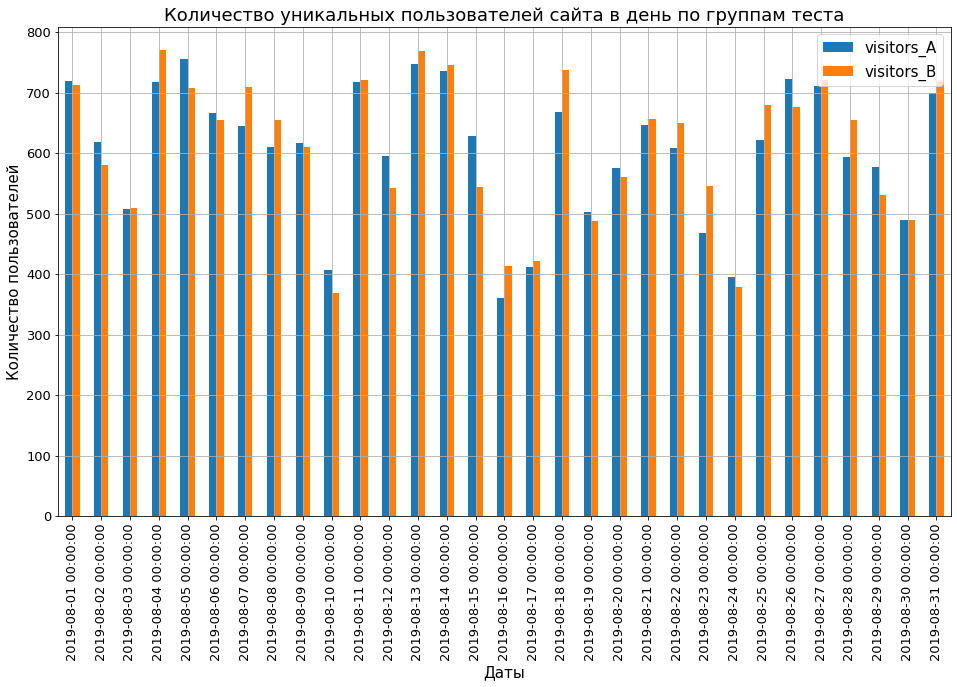

In [16]:
visitors_grouped.plot(x='date', y=['visitors_A', 'visitors_B'], kind='bar', 
                                            figsize=(16,9), grid=True, fontsize=13)

plt.title('Количество уникальных пользователей сайта в день по группам теста',
          fontsize=18)
plt.ylabel('Количество пользователей', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

Активность пользователей по дням изменялась синхронно в обеих группах теста. Наличие общего колебания кольчества пользователей в разные дни связано, скорее всего, с отличающимся поведением пользователей в будние дни и в выходные. Среднее число посетителей сайта в каждой группе теста составляет порядка 550 пользователей в день.

Теперь обратимся к датафрейму `orders` с заказами пользователей. Проверим, что диапазон дат и визитов на сайт совпадают.

In [56]:
orders['date'].describe(datetime_is_numeric=True)

count                             1197
mean     2019-08-15 13:06:46.015043328
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

Данные по заказам также, как и по визитам, представлены в промежутке с 1 по 31 августа 2019 года.

Рассчитаем среднее число заказов на одного пользователя за месяц:

In [18]:
orders.groupby('visitorId').agg({'transactionId': 'count'}).mean()

transactionId    1.161009
dtype: float64

В среднем на одного пользователя приходится 1,16 заказов в месяц.

Найдем средний чек для интернет-магазина за август 2019-го года:

In [19]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Среднее значение выручки с одного заказа за август - 8 348 усл. ед. Однако, разброс среднего чека довольно большой: минимальное и максимальное значение выручки отличаются на 5 порядков. Отличие медианного значения выручки от среднего в 2,8 раза (медианное значение выручки - 2 978 усл. ед.) так же указывает на начилие выбросов в выручке в сторону дорогих заказов. Построим гистограмму распределения значений выручки:

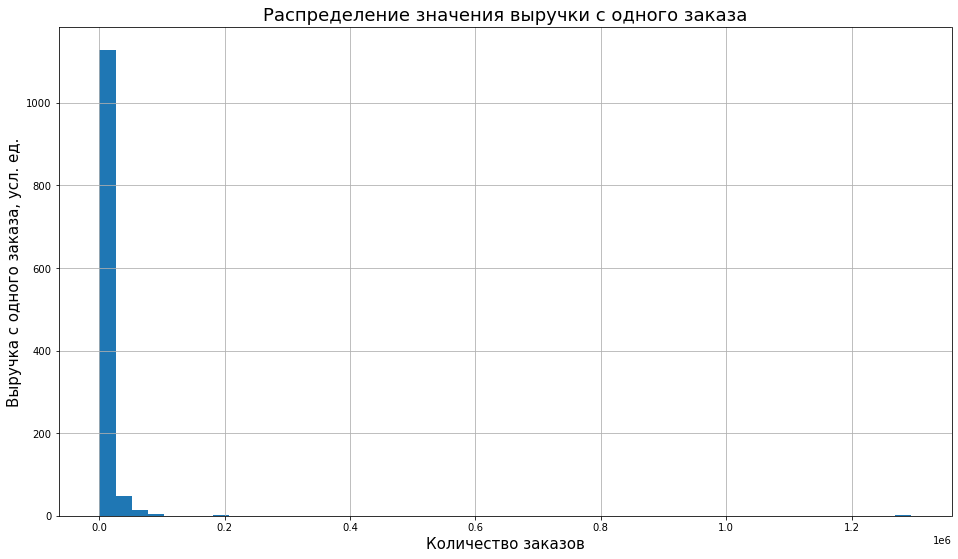

In [20]:
orders['revenue'].hist(bins=50, range=(orders['revenue'].min(), orders['revenue'].max()), 
                       figsize=(16,9), grid=True)
plt.title('Распределение значения выручки с одного заказа',fontsize=18)
plt.ylabel('Выручка с одного заказа, усл. ед.', fontsize=15)
plt.xlabel('Количество заказов', fontsize=15)
plt.show()

Как мы и предполагали, распределение выручки сильно скошено вправо. Дорогих заказов не так много, но они существенно влияют на общую картину дохода интернет-магазина.

Пронаблюдаем изменение количества заказов интернет-магазина по дням. Зависит ли этот показатель от дней недели или других сезонных активностей пользователей? Построим график:

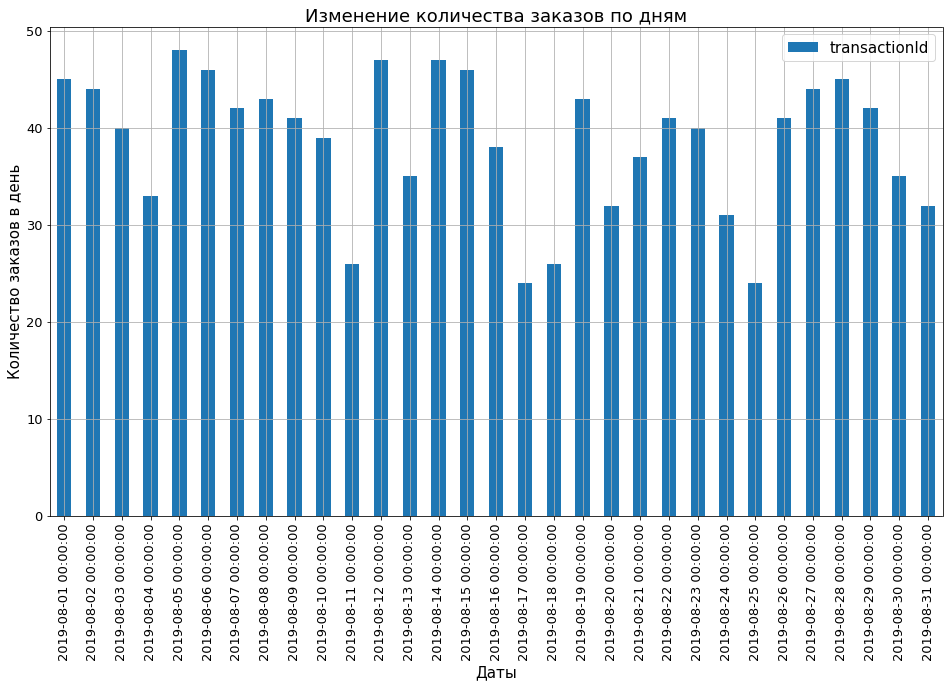

In [21]:
orders_date = orders.groupby('date').agg({'transactionId': 'count'}).reset_index()
orders_date.plot(x='date', y='transactionId', kind='bar', figsize=(16,9), 
                 grid=True, fontsize=13)

plt.title('Изменение количества заказов по дням', fontsize=18)
plt.ylabel('Количество заказов в день', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

Видим, что в выходные, вслед за уменьшением количества визитов на сайт, уменьшается и общее количество заказов. Это логичное следствие. В среднем в день пользователи суммарно совершают порядка 35 заказов и интернет-магазине.

Теперь посмотрим, как распределилось количество заказов по группам теста A и B:

In [22]:
orders.groupby('group').agg({'transactionId': 'count'})

,transactionId
group,
A,557
B,640


На группу А за месяц пришлось 557 заказов, на группу В - 640 заказов. По порядку величины имеют близкие значения, поэтому, с учетом прочих факторов, группы А и В можно сравнивать. Более подробным анализом результатов A/B-теста займемся в следующем разделе проекта.

<a id='Выводы_2'></a>
### Выводы

Мы первично познакомились с данными, содержащими информацию о количестве пользователей, зашедших на сайт в период с 1 по 31 июля 2019 года, а также информацию о совершенных за этот период заказах. В рамках подготовки представленных данных к анализу, мы изучили обозначения и типы данных переменных, убедились, что в данных отсутствуют дубликаты и пропущенные значения. Где было необходимо, произвели преобразование типов данных переменных.

В ходе изучения характерных значений присутствующих параметров, мы убедились, что диапазон дат визитов на сайт и совершения заказов совпадают, пронаблюдали в динамике изменение количества уникальных пользователей и заказов в каждый день. Построили распеделение выручки с одного заказа. Также было выявлено,что:

- Среднее число посетителей сайта в каждой группе теста составляет порядка 550 пользователей в день. При этом пользователи разделились по группам практически поровну. Суммарное число пользователей за месяц в группе А составило 18 736 человек, в группе В - 18 916 человек.


- Изменение количества пользователей сайта и совершенных заказов носит периодический характер и связано, скорее всего, с отличающимся поведением пользователей в будние дни и в выходные.


- В динамике изменения количества уникальных пользователе в день группы A и B теста ведут себя схожим образом.


- В день пользователи суммарно совершают порядка 35 заказов и интернет-магазине. При этом в месяц на одного пользователя приходится 1,16 заказов.


- Среднее значение выручки с одного заказа за август 2019 года - 8 348 усл. ед. Однако, разброс среднего чека довольно большой: минимальное и максимальное значение выручки отличаются на 5 порядков. Отличие медианного значения выручки от среднего в 2,8 раза (медианное значение выручки - 2 978 усл. ед.), а также вид распределения выручки с одного заказа, свидетельствует о начилие выбросов в выручке в сторону дорогих заказов.


- По количеству заказов группы теста разделились следующим образом: на группу А за месяц пришлось 557 заказов, на группу В - 640 заказов. По порядку данные величины имеют близкие значения, что позволяет сравнивать тестовые группы между собой. Займемся более подробным анализом результатов эксперимента в следующем разделе.

<a id='Анализ_AB_теста_Формирование_выводов'></a>
## Анализ A/B-теста. Формирование выводов

<a id='Рассчет_кумулятивных_показателей'></a>
### 1) Рассчет кумулятивных показателей

Рассчитаем кумулятивные показатели, основываясь на наших данных. Первым шагом вычислим кумулятивную выручку по группам теста. За основу берем датасет `orders`. Напомним его вид:

In [23]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


В несколько шагов рассчитаем кумулятивную выручку каждой группы теста к каждой дате. Кроме показателя выручки, добавим в таблицу с кумулятивными данными число уникальных пользователей и заказов для каждой пары "дата - группа теста":

In [24]:
# Создаем массив уникальных пар значений 'дата - группа теста', удаляя дубликаты методом drop_duplicates
date_group = orders[['date','group']].drop_duplicates()

# Получаем агрегированные по дням кумулятивные данные о заказах:
# 1) для каждой пары 'дата - группа теста' находим с помощью np.logical_and все строки таблицы orders,
# удовлетворяющие кумулятивному условию данной пары (дата <= дате из date_group, группа теста = группе 
# date_group),
# 2) для всех соответствующих найденных данных из orders внутри метода agg считаем сумму 
# уникальных заказов, уникальных пользователей, суммируем выручку,
# 3) полученную таблицу кумулятивных метрик сортируем по дате и группе теста с помощью sort_values.
orders_aggregated = date_group.apply(lambda x: 
                                     orders[np.logical_and(orders['date'] <= x['date'], 
                                                           orders['group'] == x['group'])
                                           ].agg({
                                         'date' : 'max', 
                                         'group' : 'max', 
                                         'transactionId' : pd.Series.nunique, 
                                         'visitorId' : pd.Series.nunique, 
                                         'revenue' : 'sum'}), 
                                     axis=1).sort_values(by=['date','group'])

# Переименовываем столбцы таблицы с кумулятивными данными
orders_aggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
orders_aggregated

,date,group,orders,buyers,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


Итак, мы рассчитали значения кумулятивной выручки для каждой группы теста в каждый день. Отобразим изменения этого показателя на графике:

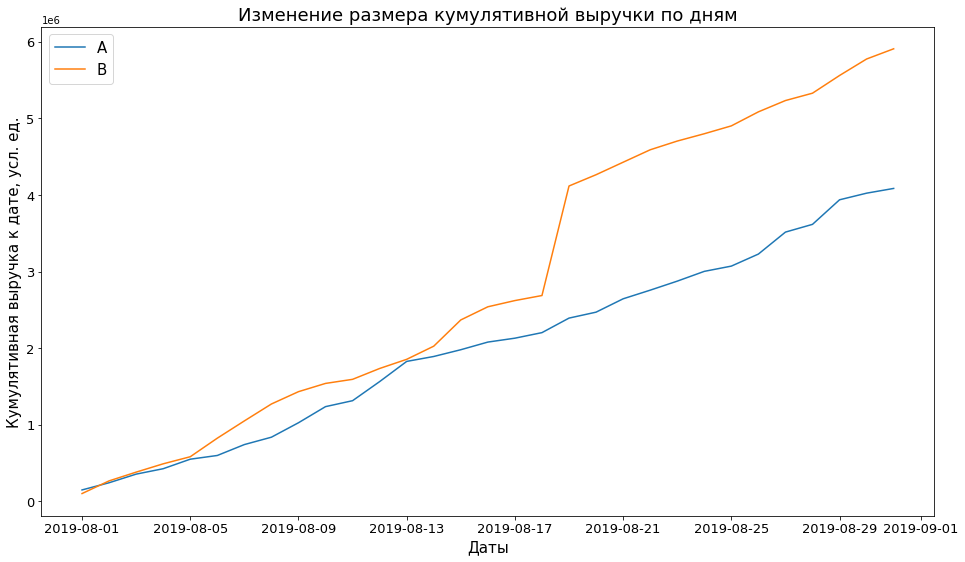

In [25]:
# Делаем срез таблицы orders_aggregated: данные только для группы А
cumulative_revenue_A = orders_aggregated[orders_aggregated['group']=='A'][[
    'date','revenue']]

# Данные только для группы B
cumulative_revenue_B = orders_aggregated[orders_aggregated['group']=='B'][[
    'date','revenue']]

# Задаем размер графика
plt.figure(figsize=(16,9))

# Строим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

# Добавляем подписи графика и меняем размер шрифта подписей
plt.title('Изменение размера кумулятивной выручки по дням', fontsize=18)
plt.ylabel('Кумулятивная выручка к дате, усл. ед.', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.show()

Видим, что в начале эксперимента различие в выручке между группами теста было невелико, но после 18 августа группа B довольно резко стала приносить больше дохода интернет-магазину. Могли повлиять выбросы в виде дорогостоящих заказов. 

Рассчитаем кумулятивный средний чек и кумулятивную конверсию в каждой группе теста. Для этого, аналогично подсчету кумулятивной выручки, получим информацию о суммарном количестве посетителей сайта, накопленном к каждой дате:

In [26]:
# Аналогично заказам, получаем агрегированные по дням кумулятивные данные о количестве посетителей 
# интернет-магазина 
visitors_aggregated = date_group.apply(lambda x: 
                                       visitors[np.logical_and(
                                           visitors['date'] <= x['date'], 
                                           visitors['group'] == x['group'])
                                               ].agg({
                                           'date' : 'max', 
                                           'group' : 'max', 
                                           'visitors' : 'sum'}), 
                                       axis=1).sort_values(by=['date','group'])

visitors_aggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Объединяем кумулятивные данные в одной таблице `cumulative_data`:

In [27]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


Средний чек - стоимость одного заказа - рассчитаем, поделив столбец `revenue` на столбец `orders`:

In [28]:
cumulative_data['revenue_per_order'] = cumulative_data['revenue'] / cumulative_data['orders']
cumulative_data

,date,group,orders,buyers,revenue,visitors,revenue_per_order
0,2019-08-01,A,24,20,148579,719,6190.791667
1,2019-08-01,B,21,20,101217,713,4819.857143
2,2019-08-02,A,44,38,242401,1338,5509.113636
3,2019-08-02,B,45,43,266748,1294,5927.733333
4,2019-08-03,A,68,62,354874,1845,5218.735294
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,9327.848993
58,2019-08-30,A,545,493,4022970,18037,7381.596330
59,2019-08-30,B,620,567,5774631,18198,9313.920968
60,2019-08-31,A,557,503,4084803,18736,7333.578097


Построим график изменения кумулятивного среднего чека в группам теста с течением времени:

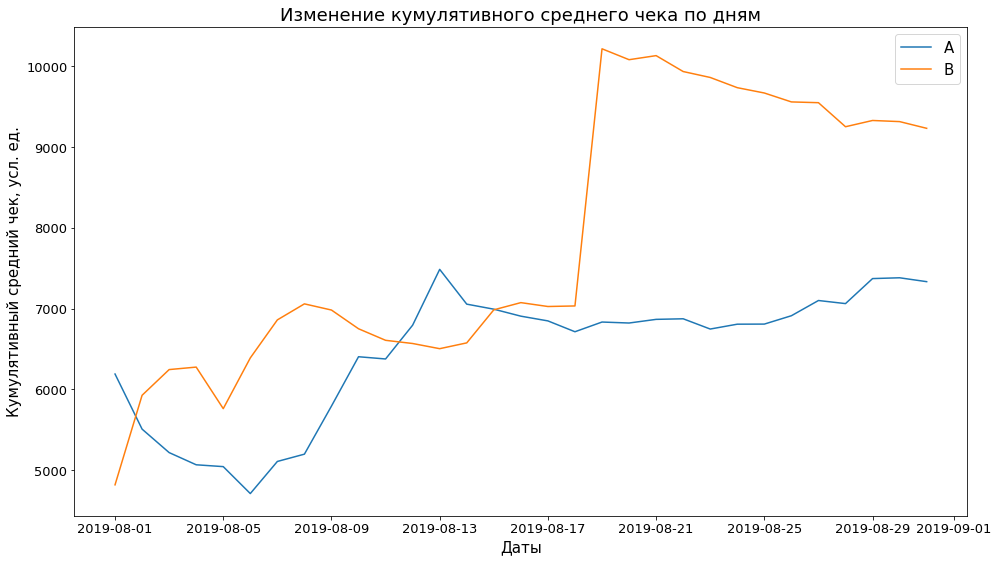

In [29]:
# Делаем срез таблицы cumulative_data: данные только для группы А
cumulative_data_A = cumulative_data[cumulative_data['group']=='A'][[
    'date', 'revenue_per_order']]

# Данные только для группы B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B'][[
    'date', 'revenue_per_order']]

# Задаем размер графика
plt.figure(figsize=(16,9))

# Строим графики среднего чека для группы А и группы B
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue_per_order'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue_per_order'], label='B')

# Добавляем подписи графика и меняем размер шрифта подписей
plt.title('Изменение кумулятивного среднего чека по дням', fontsize=18)
plt.ylabel('Кумулятивный средний чек, усл. ед.', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.show()

Кумулятивный средний чек также имеет резкие скачки изменения значения. Особенно это выражено в данных группы В. Скорее всего в данных за 18-19 августа есть дорогие заказы. Их наличие проанализируем чуть позже.

Построим график относительного изменения кумулятивного среднего чека группы В относительно группы А:

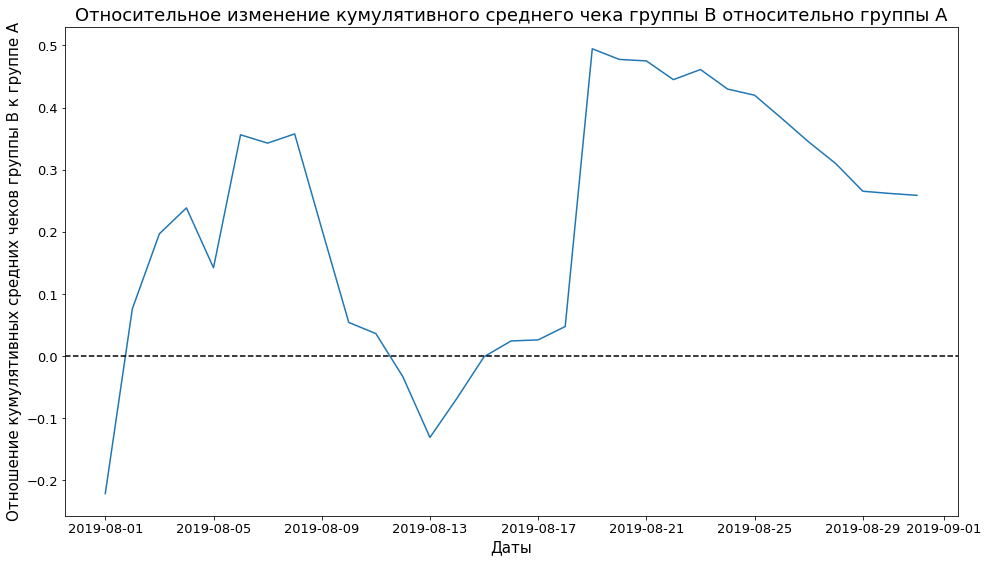

In [30]:
# Cобираем данные для групп А и В в разных столбцах одного датафрейма
merged_сumulative_data = cumulative_data_A.merge(
    cumulative_data_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Задаем размер графика
plt.figure(figsize=(16,9))

# Строим на графике отношение средних чеков группы В относительно группы А
plt.plot(merged_сumulative_data['date'], 
         merged_сumulative_data['revenue_per_orderB'] / \
         merged_сumulative_data['revenue_per_orderA'] - 1)

# Добавляем пунктирную ось X на уровне Y=0
plt.axhline(y=0, color='black', linestyle='--') 

# Добавляем подписи графика и меняем размер шрифта подписей
plt.title('Относительное изменение кумулятивного среднего чека группы В относительно группы А',
          fontsize=18)
plt.ylabel('Отношение кумулятивных средних чеков группы В к группе А', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Резкие скачки кумулятивного среднего чека группы В относительно группы А в нескольких местах графика также указывают на наличие в данных в виде дорогих заказов.

Теперь, аналогично среднему чеку, проанализируем поведение кумулятивной конверсии в группах A/B-теста. Для этого добавим в таблицу `cumulative_data` столбец с подсчитанной конверсией из посетителей сайта и покупателей, совершивших заказ:

In [31]:
cumulative_data['cr'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors,revenue_per_order,cr
0,2019-08-01,A,24,20,148579,719,6190.791667,0.033380
1,2019-08-01,B,21,20,101217,713,4819.857143,0.029453
2,2019-08-02,A,44,38,242401,1338,5509.113636,0.032885
3,2019-08-02,B,45,43,266748,1294,5927.733333,0.034776
4,2019-08-03,A,68,62,354874,1845,5218.735294,0.036856
...,...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,9327.848993,0.033657
58,2019-08-30,A,545,493,4022970,18037,7381.596330,0.030216
59,2019-08-30,B,620,567,5774631,18198,9313.920968,0.034070
60,2019-08-31,A,557,503,4084803,18736,7333.578097,0.029729


Построим график изменения кумулятивной конверсии по группам теста:

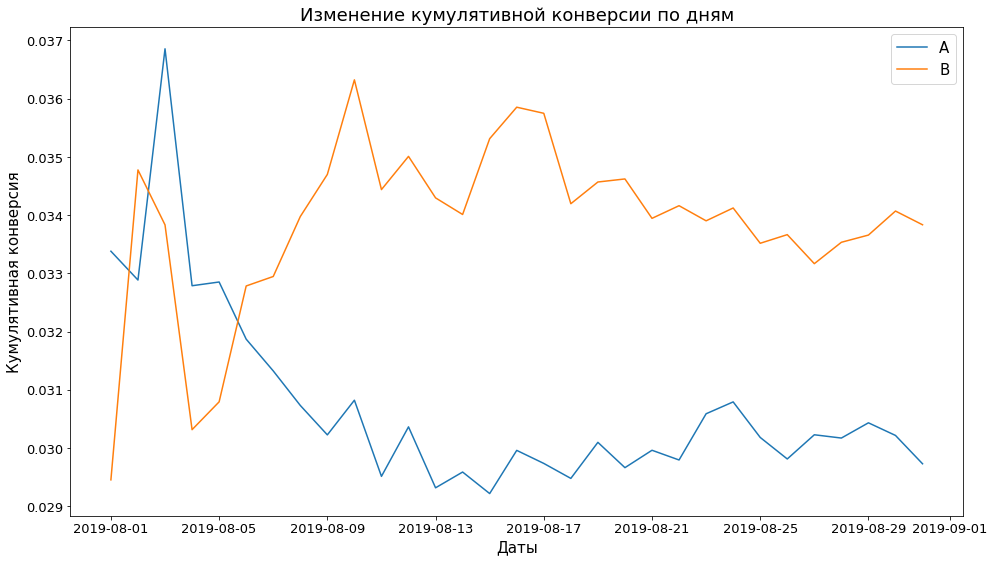

In [32]:
# Делаем срез таблицы cumulative_data: данные только для группы А
cumulative_cr_A = cumulative_data[cumulative_data['group']=='A'][['date', 'cr']]

# Данные только для группы B
cumulative_cr_B = cumulative_data[cumulative_data['group']=='B'][['date', 'cr']]

# Задаем размер графика
plt.figure(figsize=(16,9))

# Строим графики кумулятивной конверсии для группы А и группы B
plt.plot(cumulative_cr_A['date'], cumulative_cr_A['cr'], label='A')
plt.plot(cumulative_cr_B['date'], cumulative_cr_B['cr'], label='B')

# Добавляем подписи графика и меняем размер шрифта подписей
plt.title('Изменение кумулятивной конверсии по дням', fontsize=18)
plt.ylabel('Кумулятивная конверсия', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.show()

Сначала колебания конверсий в обеих группах были существенными. После 6 августа конверсия группы В стала превосходить конверсию в группе А и удержала эту позицию до конца месяца. После 18 августа колебания конверсии в обеих группах снизились по амплитуде, на основании чего можно предположить, что значения конверсий в группах теста на конец месяца установились.

Построим график относительного изменения кумулятивной конверсии в группе В относительно группы А:

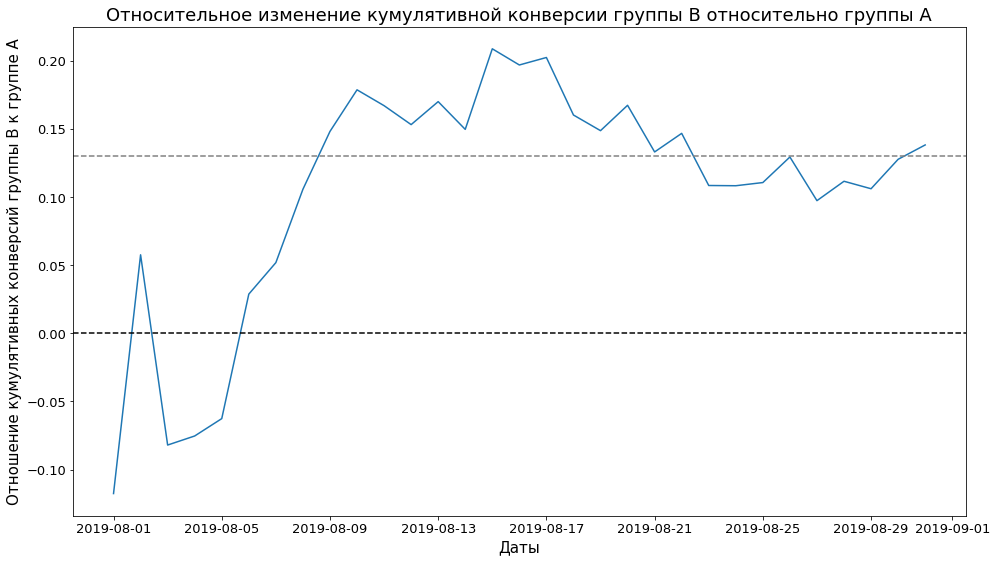

In [33]:
# Cобираем данные для групп А и В в разных столбцах одного датафрейма
merged_сumulative_cr = cumulative_cr_A.merge(
    cumulative_cr_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Задаем размер графика
plt.figure(figsize=(16,9))

# Строим на графике отношение конверсии группы В относительно группы А
plt.plot(merged_сumulative_cr['date'], 
         merged_сumulative_cr['crB'] / merged_сumulative_cr['crA'] - 1)

# Добавляем пунктирную ось X на уровне Y=0 и Y=0.13
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.13, color='grey', linestyle='--')

# Добавляем подписи графика и меняем размер шрифта подписей
plt.title('Относительное изменение кумулятивной конверсии группы В относительно группы А',
          fontsize=18)
plt.ylabel('Отношение кумулятивных конверсий группы В к группе А', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

В начале конверсия группы В относительно группы А вела себя довольно хаотично, но начиная с 6 числа начала уверенно расти и к 9 августа установила разрыв с группой А примерно в 15%. После этого наблюдалось небольное снижение конверсии группы В относительно группы А. Во второй половине месяца конверсия группы В была выше конверсии группы А на 10% и в конце месяца демонсрировала тенденцию к росту.

В целом, конверсия группы В уже долгое время превосходит конверсию группы А на 10-15%, но, чтобы принять решение о продолжении или остановке теста, необходимо проанализировать выбросы в данных. Этим и займемся в следующем разделе.

<a id='Анализ_выбросов_в_данных'></a>
### 2) Анализ выбросов в данных

Исследуем, есть ли среди пользователей клиенты, совершающие аномально много заказов относительно всей аудитории пользователей. Клиенты, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего их поведение отличается от остальной аудитории пользователей. Выявим их - рассчитаем на каждого пользователя количество его заказов за август 2019 года:

In [34]:
visitors_orders = orders[['visitorId', 'transactionId']].groupby('visitorId').agg({
    'transactionId': pd.Series.nunique}).reset_index()
visitors_orders.columns = ['visitorId', 'orders']
visitors_orders.sort_values(by='orders', ascending=False)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


Построим точечный график количества заказов по пользователям. Сделаем это с помощью метода `plt.scatter()`:

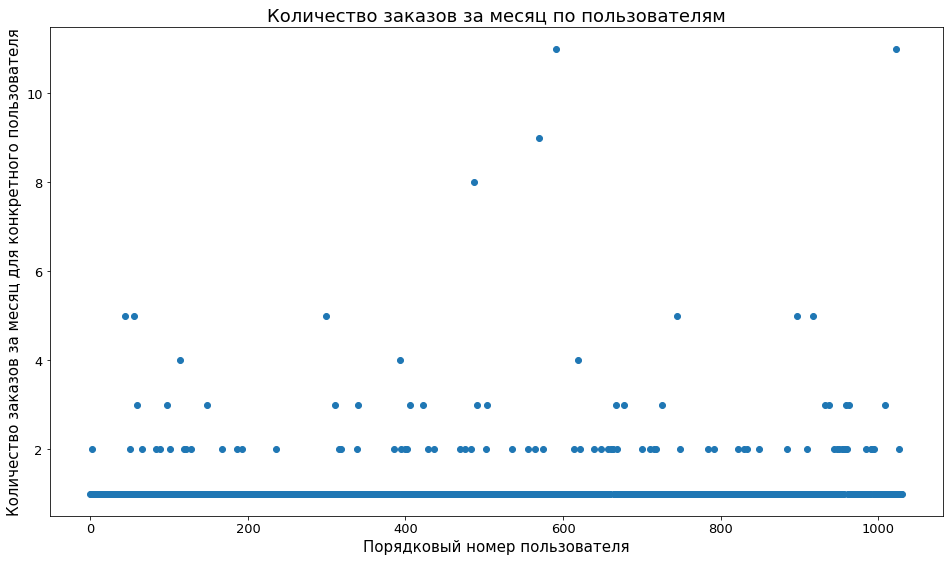

In [35]:
plt.figure(figsize=(16,9))

plt.scatter(pd.Series(range(0,len(visitors_orders['orders']))), 
            visitors_orders['orders'])

plt.title('Количество заказов за месяц по пользователям', fontsize=18)
plt.ylabel('Количество заказов за месяц для конкретного пользователя', fontsize=15)
plt.xlabel('Порядковый номер пользователя', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Действительно, есть небольшое количество пользователей, совершивших более 2-3 заказов в августе 2019-го. Вероятно, какие-то товары им приглянулись, и они захотели дозаказать что-то. Могло быть и так, что не весь товар был на складе и пользователю пришлось разделить свою покупку на несколько заказов по периодам поставки товаров. Если это так, то хорошо, что таких клиентов относительно немного.

Для того, чтобы более обосновано (чем глядя на график) выбрать границу анамольных пользователей, рассчитаем 95-й и 99-й перцентили количества заказов на пользователя. Сделаем это методом `np.percentile`:

In [36]:
np.percentile(visitors_orders['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершают свыше 2 заказов в месяц и не более 1% - свыше 4 заказов. Выберем верхнюю границу в **2 заказа в месяц** на одного пользователя как критерий, по которому отсеим аномальных клиентов.

Теперь исследуем аномально дорогие заказы. Постоем точечный график, аналогичный последнему, но теперь для параметра выручки с одного заказа `revenue`:

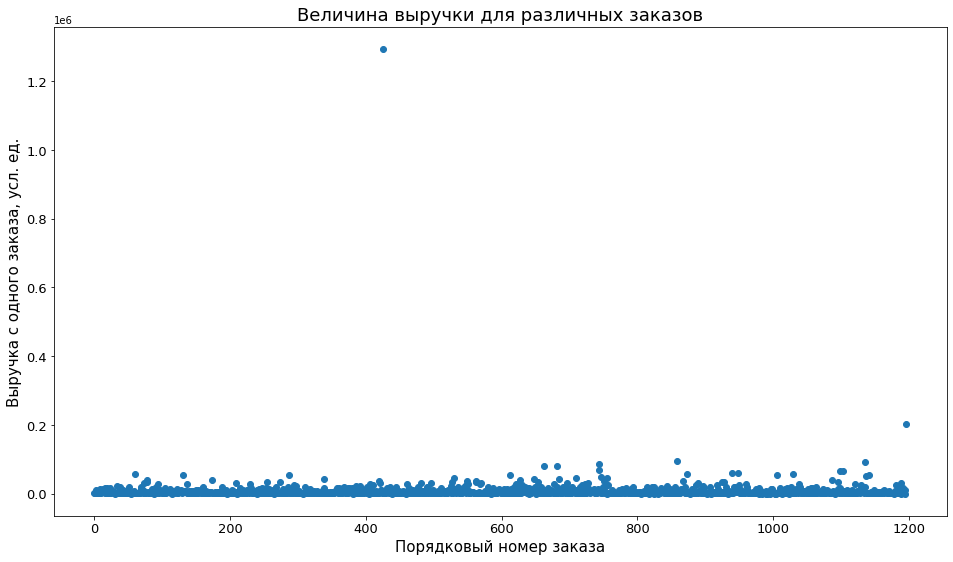

In [37]:
plt.figure(figsize=(16,9))

plt.scatter(pd.Series(range(0,len(orders['revenue']))), orders['revenue'])

plt.title('Величина выручки для различных заказов', fontsize=18)
plt.ylabel('Выручка с одного заказа, усл. ед.', fontsize=15)
plt.xlabel('Порядковый номер заказа', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

На фоне заказа стоимостью 1,2 млн., все остальные "вжались" в ноль. Построим тот же график, но в диапазоне до 200 тыс. усл. ед.:

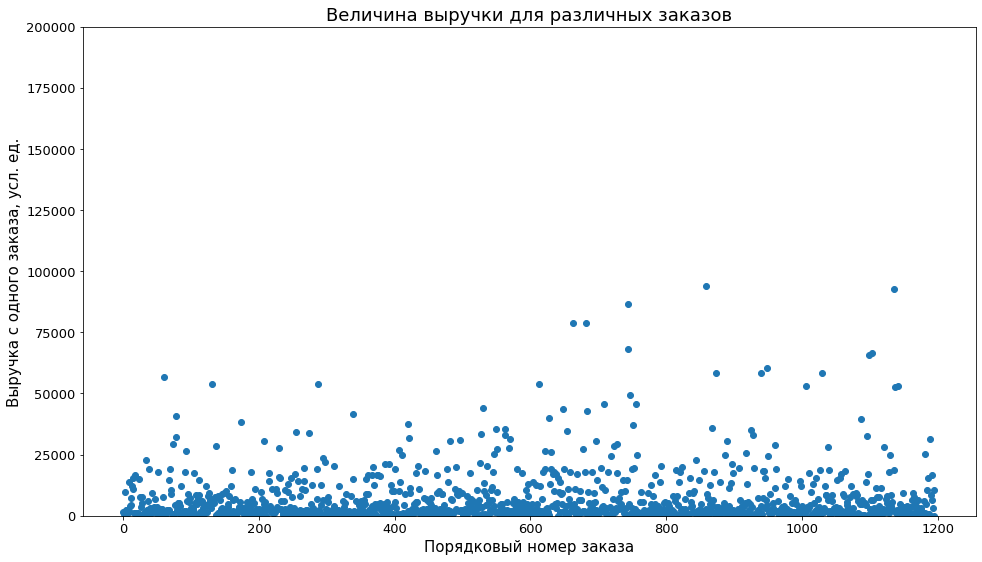

In [38]:
plt.figure(figsize=(16,9))

plt.scatter(pd.Series(range(0,len(orders['revenue']))), orders['revenue'])

plt.title('Величина выручки для различных заказов', fontsize=18)
plt.ylabel('Выручка с одного заказа, усл. ед.', fontsize=15)
plt.xlabel('Порядковый номер заказа', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0,200000)
plt.show()

Большинство заказов принесло выручки менее 25 тыс., но есть и более дорогие "выбросы". Оценим 95-й и 99-й перцентили стоимости заказов:

In [39]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28 тыс. усл. ед. и не более 1% - дороже 58 233 усл. ед. Выберем за границу "нормальных" заказов стоимость в **28 тыс.** усл. ед. таким образом мы отсечем 5% заказов - самых дорогих.

Мы убедились, что в наших данных действительно присутствуют выбросы по стоимости заказов и по количеству заказов на одного пользователя. В этом разделе мы определили **границу, по которой будем отсекать аномальных пользователей**: совершивших более 2 заказов за месяц или совершивших заказ дороже 28 тыс. усл. ед.

В следующей части проекта займемся определением статистически значимых различий в группах А/В-теста, как на "сырых" данных, так и с учетом отсева аномальных пользователей.

<a id='Определение_статистической_значимости_различий_в_группах_теста'></a>
### 3) Определение статистической значимости различий в группах теста

Для дальнейшего анализа данных и оценки статистической значимости различий в грппах теста, подготовим такую таблицу: для каждой даты заведем столбцы (в двух экземплярах - для каждой группы теста) с ежедневными и кумулятивными значениеми показателей - количеством заказов, выручкой и количеством пользователей. Из датафрейма `visitors` получим текущее и кумулятивное количество пользователей на каждую дату в каждой группе теста:

In [40]:
# Ежедневное количество пользователей
visitors_daily_A = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_daily_A.columns = ['date', 'visitors_per_date_A']

visitors_daily_B = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_daily_B.columns = ['date', 'visitors_per_date_B']

# Суммарное количество пользователей к дате
visitors_cummulative_A = visitors_daily_A.apply(lambda x: 
                            visitors_daily_A[visitors_daily_A['date'] <= x['date']].agg({
                                'date' : 'max', 'visitors_per_date_A' : 'sum'}), axis=1)
visitors_cummulative_A.columns = ['date', 'visitors_cummulative_A']

visitors_cummulative_B = visitors_daily_B.apply(lambda x: 
                            visitors_daily_B[visitors_daily_B['date'] <= x['date']].agg({
                                'date' : 'max', 'visitors_per_date_B' : 'sum'}), axis=1)
visitors_cummulative_B.columns = ['date', 'visitors_cummulative_B']

display(visitors_daily_A.head(), visitors_daily_B.head(), 
        visitors_cummulative_A.head(), visitors_cummulative_B.head())

,date,visitors_per_date_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitors_per_date_B
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


,date,visitors_cummulative_A
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


,date,visitors_cummulative_B
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


Из датафрейма `orders` получим ежедневные и кумулятивные значения количества заказов и величины выручки для групп теста:

In [41]:
# Ежедневное количество заказов и размер выручки
orders_daily_A = orders[orders['group']=='A'][['date', 'transactionId','visitorId', 
                                               'revenue']].groupby(
    'date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
orders_daily_A.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_daily_B = orders[orders['group']=='B'][['date', 'transactionId','visitorId', 
                                               'revenue']].groupby(
    'date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
orders_daily_B.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# Кумулятивные данные по количеству заказов и выручке
orders_cummulative_A = orders_daily_A.apply(
    lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']].agg({
                'date' : 'max',
                'orders_per_date_A' : 'sum',
                'revenue_per_date_A' : 'sum'}), axis=1).sort_values(by=['date'])
orders_cummulative_A.columns = ['date', 'orders_сummulative_A', 'revenue_сummulative_A']

orders_cummulative_B = orders_daily_B.apply(
    lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']].agg({
                'date' : 'max',
                'orders_per_date_B' : 'sum',
                'revenue_per_date_B' : 'sum'}), axis=1).sort_values(by=['date'])
orders_cummulative_B.columns = ['date', 'orders_сummulative_B', 'revenue_сummulative_B']

display(orders_daily_A.head(), orders_daily_B.head(),
        orders_cummulative_A.head(), orders_cummulative_B.head())

,date,orders_per_date_A,revenue_per_date_A
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


,date,orders_per_date_B,revenue_per_date_B
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


,date,orders_сummulative_A,revenue_сummulative_A
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


,date,orders_сummulative_B,revenue_сummulative_B
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


Объединим полученные данные в одну таблицу `data`:

In [42]:
data = visitors_daily_A.merge(
    visitors_daily_B, left_on='date', right_on='date', how='left').merge(
    visitors_cummulative_A, left_on='date', right_on='date', how='left').merge(
    visitors_cummulative_B, left_on='date', right_on='date', how='left').merge(
    orders_daily_A, left_on='date', right_on='date', how='left').merge(
    orders_daily_B, left_on='date', right_on='date', how='left').merge(
    orders_cummulative_A, left_on='date', right_on='date', how='left').merge(
    orders_cummulative_B, left_on='date', right_on='date', how='left')

data.head()

,date,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_сummulative_A,revenue_сummulative_A,orders_сummulative_B,revenue_сummulative_B
0,2019-08-01,719,713,719,713,24,148579,21,101217,24,148579,21,101217
1,2019-08-02,619,581,1338,1294,20,93822,24,165531,44,242401,45,266748
2,2019-08-03,507,509,1845,1803,24,112473,16,114248,68,354874,61,380996
3,2019-08-04,717,770,2562,2573,16,70825,17,108571,84,425699,78,489567
4,2019-08-05,756,707,3318,3280,25,124218,23,92428,109,549917,101,581995


Мы хотим посчитать статистическую значимость различия конверсий в группах теста. Конверсия - это количество заказов, деленное на количество пользователей. Рассчитаем количество заказов для каждого пользователя:

In [43]:
orders_by_visitors_A = orders[orders['group']=='A'].groupby(
    'visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
orders_by_visitors_A.columns = ['visitorId', 'orders']

orders_by_visitors_B = orders[orders['group']=='B'].groupby(
    'visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
orders_by_visitors_B.columns = ['visitorId', 'orders']

display(orders_by_visitors_A.head(), orders_by_visitors_B.head())

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


,visitorId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Дополним столбцы `orders` из списков `orders_by_visitors_A` и `orders_by_visitors_B` нулями в том количестве, сколько пользователей не совершило ни одного заказа за месяц. Осуществим этот шаг, объединив уже имеющиеся списки выше и столбец с нулями заказов для остальных пользователей методом `concat`. Новые списки количества заказов назовем `sampleA` и `sampleB`:

In [44]:
sampleA = pd.concat([orders_by_visitors_A['orders'],
                     pd.Series(0, index=np.arange(
                         # вычисляем количество пользователей, не совершивших ни одного заказа
                         data['visitors_per_date_A'].sum() -\
                         len(orders_by_visitors_A['orders'])),
                               name='orders')],axis=0)

sampleB = pd.concat([orders_by_visitors_B['orders'],
                     pd.Series(0, index=np.arange(
                         data['visitors_per_date_B'].sum() -\
                         len(orders_by_visitors_B['orders'])), 
                               name='orders')],axis=0)

display(sampleA, sampleB)

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18736, dtype: int64

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18916, dtype: int64

Число элементов в каждом списке - `sampleA` и `sampleB` - количество пользователей в группах А и В теста, Сумма значений этих элементов - число заказов в каждой группе. Теперь конверсию каждой группы теста можно найти поделив число заказов на количество пользователей или, другими словами, посчитать среднее по спискам `sampleA` и `sampleB`. Статистическую значимость различия в конверсиях будем проверять по критерию Манна-Уитни. Перед тем, как производить проверку, сформулируем нулевую и альтернативную гипотезы:

**Нулевая гипотеза H0:** конверсия в группе теста A равна конверсии в группе теста B.

**Альтернативная гипотеза H1:** конверсии в группах A и B теста различаются.

Осуществим проверку нулевой гипотезы методом `mannwhitneyu` библиотеки `scipy.stats`. За **критический уровень** статистической значимости примем значение `p-value` = 0,05:

In [45]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.008


Значение p-value при оценке конверсий равно 0,008, что меньше выбранного уровня статистической значимости, следовательно, мы принимаем решение откинуть нулевую гипотезу и придерживаемся альтернативной гипотезы, согласно которой различие в конверсиях групп А и В на "сырых" данных присутствует. Посчитаем относительное отличие конверсии в группе В относительно группы А:

In [46]:
print('{0:.1%}'.format(sampleB.mean() / sampleA.mean()-1))

13.8%


Конверсия в группе В на "сырых" данных (без фильтрации выбросов) выше конверсии в группе А на 13,8%.

Обратимся к параметру среднего чека и посчитаем для него значение p-value уровня статистической значимости различий в группах теста. Сформулируем нулевую и альтернативную гипотезы для параметра среднего чека:

**Нулевая гипотеза H0:** средний чек в группе теста A равен среднему чеку в группе теста B.

**Альтернативная гипотеза H1:** средний чек в группах A и B теста различается.

Средний чек можно рассчитать, найдя среднее значение по столбцу `revenue` датафрейма `orders`. Произведем проверку равенства средних чеков по критерию Манна-Уитни. Уровень статистической значимости также выберем равным 0,05:

In [47]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

0.365


По "сырым" данным значение p-value = 0,365 выше установленного уровня 0,05, следовательно, у нас нет оснований отвергать нулевую гипотезу о равенстве средних чеков в группах А и В теста. Однако, после фильтрации выбросов картина может измениться.

Найдем количество аномальных пользователей. Напомним, что за аномальных пользователей мы принимаем тех, кто либо совершил более 2 заказов за месяц, либо совершил заказ дороже 28 тыс. усл. ед.

In [48]:
# Ранее мы получали списки клиентов с количеством заказов на каждого пользователя orders_by_visitors_A и 
# orders_by_visitors_B. Найдем тех пользователей, кто совершил более 2 заказов
visitors_with_many_orders = pd.concat([orders_by_visitors_A[
    orders_by_visitors_A['orders'] > 2]['visitorId'], 
    orders_by_visitors_B[orders_by_visitors_B['orders'] > 2]['visitorId']], axis = 0)

# По столбцу orders['revenue'] найдем тех, кто совершал покупки дороже 28 тыс.
visitors_with_expensive_orders = orders[orders['revenue'] > 28000]['visitorId']

# Объединим два списка пользователей методом concat
abnormal_visitors = pd.concat([visitors_with_many_orders, visitors_with_expensive_orders],
                          axis = 0).drop_duplicates().sort_values()

abnormal_visitors

1099     148427295
18       199603092
928      204675465
23       237748145
37       249864742
           ...    
723     4009017467
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Name: visitorId, Length: 74, dtype: int64

Длина этого списка - количество аномальных пользователей:

In [49]:
len(abnormal_visitors)

74

Пользователей, поведение которых приводит к выбросам в данных, 74. В процентном соотношении от всех пользователей, совершивших хотя бы один заказ, это:

In [50]:
print('{0:.1%}'.format(len(abnormal_visitors) / len(orders['visitorId'].unique())))

7.2%


Производя фильтрацию выбросов мы откидываем данные по 7% клиентам. Это не слишком много, зато позволяет в дальнейшем работать с более однородными данными.

Узнаем, как избавление от выбросов повлияет на различие в конверсиях и средних чеках групп теста. Подготовим выборки для проверки статистически значимых различий упомянутых величин. Для этого, как и раньше, подготовим список количества заказов для каждой группы теста:

In [51]:
# В таблице orders_by_visitors_A посчитано количество заказов на каждого пользователя. 
# Находим среди них пользователей, не вошедших в список аномальных abnormal_visitors,
# и берем для них количество заказов. 
# Дополняем выборку нулями в количестве оставшихся пользователей. 
# Общее число пользователей в группе теста известно из столбца 
# data['visitors_per_date_A'] - это его сумма
sampleA_filtered = pd.concat([
    orders_by_visitors_A[np.logical_not(
        orders_by_visitors_A['visitorId'].isin(abnormal_visitors))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - \
                                 len(orders_by_visitors_A['orders'])),name='orders')],axis=0)

# Аналогично рассчитываем количество заказов на пользователя в группе B
sampleB_filtered = pd.concat([
    orders_by_visitors_B[np.logical_not(
        orders_by_visitors_B['visitorId'].isin(abnormal_visitors))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - \
                                 len(orders_by_visitors_B['orders'])),name='orders')],axis=0)

display(sampleA_filtered, sampleB_filtered)

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18690, dtype: int64

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18869, dtype: int64

Оценим статистически значимое различие конверсий по критерию Манна-Уитни. Нулевая гипотеза звучит точно также, как мы ее уже формулировали: группы А и В теста имеют одинаковое значение конверсий. Альтернативная гипотеза утверждает о различии конверсий в группах теста. Критический уровень статистической значимости все тот же - 0,05:

In [52]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))

0.007


Значение p-value ниже уровня 0,05 - отвергаем нулевую гипотезу. Различия в конверсиях групп А и В присутствуют. Найдем относительное различие конверсий:

In [53]:
print("{0:.1%}".format(sampleB_filtered.mean() / sampleA_filtered.mean()-1)) 

17.3%


Различие в конверсия увеличилось с 13,8% на "сырых" данных до 17,3% на отфильтрованных данных. Группа В демонстрирует лучший показатель конверсии.

Посмотрим, появилось ли после фильтрации данных различие в средних чеках групп теста. Напомним, что нулевая гипотеза утверждает равенство средних чеков в группе А и в группе В, а альтернативная гипотеза говорит о наличии отличий в значении среднего чека для этих групп. Проверим критерий Манна-Уитни:

In [54]:
# Получаем значение p-value метода Манна-Уитни
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_visitors)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormal_visitors)))]['revenue'])[1]))

# Считаем относительную разницу среднего чека в группе В относительно группы А
print('{0:.1%}'.format(
orders[np.logical_and(orders['group']=='B',np.logical_not(
    orders['visitorId'].isin(abnormal_visitors)))]['revenue'].mean() / \
    orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormal_visitors)))]['revenue'].mean() - 1))

0.369
-2.0%


Значение p-value выше критического уровня значимости. Мы по-прежденему не можем утверждать отличие средних чеков в группах теста.

Подведем итоги по всему текущему разделу.

<a id='Выводы_3'></a>
## Выводы

В первой части данного раздела мы построили груфики кумулятивных показателей отдельно для каждой группы теста. Исследовались такие параметры, как кумулятивная выручка, средний чек и величина конверсии в каждой группе. Скачкообразное поведение исследуемых характеристик в некоторые даты указывает на наличие в данных выбросов и аномальных значений. Особенно это заметно на характеристиках группы В.

В начале эксперимента различие в выручке между группами теста было невелико, но после 18 августа в группе B довольно резко увеличился показатель выручки. Кумулятивный средний чек также имеет резкие скачки изменения значений. Колебания конверсий в обеих группах в начале теста были существенными. После 6 августа конверсия группы В стала превосходить конверсию в группе А и удержала эту позицию до конца месяца. После 18 августа колебания конверсии в обеих группах снизились по амплитуде, на основании чего можно предположить, что значения конверсий в группах теста на конец месяца установились.

Относительное отличие конверсии группы В, по сравнению с группой А, начиная с 6 августа стало уверенно расти и к 9 августа установился разрыв примерно в 15%. После этого наблюдалось небольное снижение конверсии группы В относительно группы А до 10%, но к концу месяца конверсия в группе В демонсрировала тенденцию к росту.

Оценка выбросов в данных показала, что действительно, есть пользователи, совершившие более 2 заказов в августе 2019-го. Однако, их не более 5%, и не более 1% пользователей совершили свыше 4 заказов. В средней стоимости заказа мы также нашли отклонения ряда заказов от общей картины. Рассчитав перцентили выручки, мы выяснили, что не более 5% заказов дороже 28 тыс. усл. ед. и не более 1% - дороже 58 233 усл. ед. Определили границу, по которой будем отсекать аномальных пользователей: совершивших более 2 заказов за месяц или совершивших заказ дороже 28 тыс. усл. ед. Таких пользователей 74, что в процентном отношении от всех пользователей, совершивших хотя бы один заказ, составляет 7,2 %.

В завершение данного раздела мы провели оценку статистической значимости различия в конверисия групп теста по критерию Манна-Уитни. Значение p-value данного метода указало на наличие статистически значимого различия в конверсиях групп А и В. Критический уровень статистической значимости был выбран 0,05. Согласно рассчетам, конверсия в группе В на "сырых" данных (без фильтрации выбросов) выше конверсии в группе А на 13,8%. При этом, после отсекания аномальных пользователей, различие в конверсия увеличилось до 17,3%. Группа В демонстрирует лучший показатель конверсии. 

Также оценивалось различие в показателях среднего чека для двух групп. Основываясь на критерии Манна-Уитни и выбранном критическим уровнем статистической значимости в 0,05 мы не можем утверждать отличие средних чеков в группах А и В теста. Как на "сырых" данных, так и на отфильтрованных.

<a id='Общий_вывод'></a>
## Общий вывод

В ходе проекта мы провели приоризацию гипотез, направленных на увеличение выручки интернет-магазина, а также проанализировали результаты А/В-тестирования по данным о посетителях сайта и совершенных ими заказах.

В первой части проекта приоритизация гипотез производилась по двум фреймворкам: ICE и RICE. Было показано, как учет нараметра Rich охвата аудитории повлиял на порядок проверки гипотез.

Во второй части проекта производился анализ результатов А/В-теста на представленных данных о посещениях сайта интернет-магазина и данных о заказах пользователей. Данные были изучены и подготовлены к анализу, были получены характерные значения фигурирующих в датафреймах переменных. Выявлен периодичный характер изменения количества визитов и заказов в динамике по времени. Непосредственно перед анализом результатов тестирования, была произведена проверка корректности распределения трафика пользователей между группами теста.

Далее были построены графики кумулятивных показателей, таких как выручка интернет-магазина, конверсия и средний чек в каждой тестовой группе. Было оценено относительное изменение кумулятивного среднего чека и кумулятивной конверсии группы В относительно группы А. Был отмечен скачкообразный характер изменения величин в первые дни эксперимента, и уменьшение колебаний значений к концу месяца.

На основе проведенного анализа статистической значимости полученных результатов можно сделать вывод, что значения в показателях конверсий в группах теста установились. При этом тестовая группа В демонстрирцет конверсию выше конверсии в группе А на 13-17%, а средний чек в группах значительно не отличается. Учитывая все факторы, эксперимент разумно остановить и признать вариант группы В наиболее выгодным для интернет-магазина.